+ 목적
  + 월별 [문의하기] 접수 글에 대한 Trend 확인
  + 주요 문의 Category 파악
+ 적용모델 : LDA(비지도 학습)
+ 분석방향 : 토픽을 5개 및 20개로 설정하고, 해당 결과를 비교함
+ 세부내용
  + [x] data load : Excel 불러오기
  + [x] data trim : KoNLP를 이용한 자료 정제(okt.morphs 이용)
  + [x] modeling  : LDA(gensim 기반)
    + [x] model1 : 5개 topic
    + [x] model2 : 10개 topic
  + [x] predict/summary


In [1]:
import pandas as pd
import numpy as np

from konlpy.tag import Okt
okt = Okt("C:/Program Files/Java/jdk-12.0.1/bin/server/jvm.dll")
# okt = Okt()

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)                               # 한글폰트 설정(전역)

import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


### 1.자료 불러오기

In [2]:
# 자료 불러오기 :Excel 
data = pd.read_excel('./MI_CUS_INQUIRY_v1.xls')
data['text'] = data['TITE'] + ' ' + data['CTT'] 
# data = data.reset_index()

In [3]:
# 자료 확인
data.tail(2)

,OPNN_NO,OPNN_DV_CD,CNSL_SPHR_CD,TITE,CTT,REG_DTM,text
31488,32779,5,NaN,20ml스푼신청이요,궁을 구매하여 먹이고있는데요. 20ml양 늘리려니 반스푼 덜어내기 어려워 신청하고 ...,201912,20ml스푼신청이요 궁을 구매하여 먹이고있는데요. 20ml양 늘리려니 반스푼 덜어내...
31489,32780,1,NaN,둘째가 쌍둥이인데 수정이 안되네요.,내용 무,201912,둘째가 쌍둥이인데 수정이 안되네요. 내용 무


### 2.텍스트 전처리

In [4]:
# data['CTT'] = data['CTT'] .str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [5]:
# 1차 가공 : koNLpy 정제
def tokenize(doc):
#     result = [''.join(t) for t in okt.nouns(doc)] # 명사 ex ['더빙', '나다', ...]
    result = [''.join(t) for t in okt.morphs(doc)] # 말뭉치(명사+ a) ex ['더빙', '나다', ...]
#     result = ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)] # ex 품사 추가 & 동사원형['더빙/Norm', '나다/Verb', ...]
#     result = [ t for t in result if not t in ["은/Josa", "는/Josa", "이/Josa", "가/Josa", "./Punctuation", "로/Josa", "를/Josa"] ] # 어미/조사/구두점 제외
#                if not t in ["/Eomi", "/Josa", "/Punctuation"] ]             # 어미/조사/구두점 제외
    return result 

data_trim1 = [tokenize(row) for row in data['text']  ]  

In [6]:
# 2차 가공 : 역토큰화 후, 한글만 남김
data_trim2 = []
for i in range(len(data)):
    t = ' '.join(data_trim1[i])
    data_trim2.append(t)

data['clean_CTT'] = data_trim2
data['clean_CTT'] = data['clean_CTT'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [7]:
# 3차 가공 : (다시)한글 토큰만 출력
data_trim3 = [tokenize(row) for row in data['clean_CTT'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  ]  

In [8]:
# 가공 결과 비교
i =  data.sample(n=1, axis =0).index[0]
print('----------------------------------')
print(data['text'][i])        # 원본
print('----------------------------------')
print(data_trim1[i])          # 1차 변환
print('----------------------------------')
print(data['clean_CTT'][i])   # 2차 변환
print('----------------------------------')
print(data_trim3[i])          # 3차 변환

----------------------------------
임신축하박스. . 안녕하세요^^
계속  승인중이라  혹시나해서  이렇게
문의드려봅니다. . .
안된건가요? 9월달 다시  신청해야하는건지요 ㅜ ㅜ
----------------------------------
['임신', '축하', '박스', '.', '.', '안녕하세요', '^^', '\r\n', '계속', '승인', '중', '이라', '혹시', '나', '해서', '이렇게', '\r\n', '문의', '드려', '봅니다', '.', '.', '.', '\r\n', '안된건', '가요', '?', '9월', '달', '다시', '신청', '해야하는', '건지요', 'ㅜ', 'ㅜ']
----------------------------------
임신 축하 박스   안녕하세요   계속 승인 중 이라 혹시 나 해서 이렇게  문의 드려 봅니다     안된건 가요  월 달 다시 신청 해야하는 건지요 ㅜ ㅜ
----------------------------------
['임신', '축하', '박스', '안녕하세요', '계속', '승인', '중', '이라', '혹시', '나', '해서', '이렇게', '문의', '드려', '봅니다', '안된건', '가요', '월', '달', '다시', '신청', '해야하는', '건지요', 'ㅜ', 'ㅜ']


### 4. 토픽 모델링 : LDA

+ LSA : 차원 축소를 통해, Topic을 추출한다.
+ **LDA : 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽을 추출한다.**

In [10]:
from gensim import corpora

import gensim                 # LDA 모델링
import pyLDAvis.gensim        # LDA 시각화

In [12]:
# 문서 별 토픽 분포 정의
# 문서 별 토픽 분포 정의
def make_topictable_per_doc(ldamodel, corpus, texts):
    topic_table = pd.DataFrame()

    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
            else:
                break
    return(topic_table)

In [13]:
# 사전 및 말뭉치 만들기
dictionary = corpora.Dictionary(data_trim3)

# 말뭉치 내용 수정


# 말뭉치 to token화
corpus = [dictionary.doc2bow(text) for text in data_trim3]

In [14]:
%%time 

# 모형1 : 5개의 토픽 LDA
NUM_TOPICS1 = 5
ldamodel_1 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS1, id2word=dictionary, passes=15)
topics_1 = ldamodel_1.print_topics(num_words=4)

pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim.prepare(ldamodel_1, corpus, dictionary)

topictable1 = make_topictable_per_doc(ldamodel_1, corpus, data_trim1)
topictable1 = topictable1.reset_index() # 문서 번호 column 추가생성
topictable1.columns = ['문서 번호', 'TITE_GUBUN2', '가장 높은 토픽의 비중', '각 토픽의 비중']

data1 = data.copy()
data1['TITE_GUBUN2'] = topictable1['TITE_GUBUN2']
data1_vf = data1[['TITE_GUBUN2', 'text', 'REG_DTM']]

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [15]:
# 모형1 결과 확인
topictable1.tail(3)

,문서 번호,TITE_GUBUN2,가장 높은 토픽의 비중,각 토픽의 비중
31487,31487,1.0,0.9234,"[(1, 0.9233933), (3, 0.058477808)]"
31488,31488,1.0,0.4255,"[(0, 0.3335136), (1, 0.42551404), (2, 0.161419..."
31489,31489,4.0,0.7937,"[(0, 0.020313384), (1, 0.14524111), (2, 0.0200..."


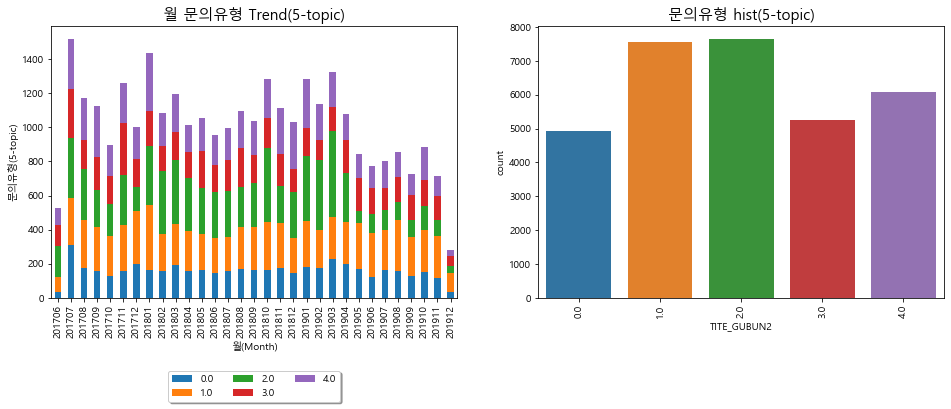

In [16]:
# 모형1 결과 시각화
mpl.rc('figure', figsize=(16, 5))

ax = plt.subplot(1,2,1)
pd.crosstab(data1_vf.REG_DTM, data1_vf.TITE_GUBUN2, data1_vf.TITE_GUBUN2, aggfunc="count").plot.bar(stacked=True, ax = ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3)
plt.xticks(rotation=90)
plt.title('월 문의유형 Trend(5-topic)',fontsize=15)
plt.xlabel('월(Month)')
plt.ylabel('문의유형(5-topic)')

ax = plt.subplot(1,2,2)
sns.countplot(x="TITE_GUBUN2", data=data1_vf)
plt.xticks(rotation=90)
# sns.countplot(x="discript", data=data1_vf)
plt.title('문의유형 hist(5-topic)',fontsize=15)

plt.show()

In [17]:
%%time 

# 모형2 : 20개의 토픽 LDA
NUM_TOPICS2 = 20
ldamodel_2 = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS2, id2word=dictionary, passes=15)
topics_2 = ldamodel_2.print_topics(num_words=4)

# 모형2 시각화
# pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(ldamodel_2, corpus, dictionary)

# 모형2 결과 정리
topictable2 = make_topictable_per_doc(ldamodel_2, corpus, data_trim1)
topictable2 = topictable2.reset_index() # 문서 번호 column 추가생성
topictable2.columns = ['문서 번호', 'TITE_GUBUN2', '가장 높은 토픽의 비중', '각 토픽의 비중']

# 모형2 결과 + 원자료 merge
data2 = data.copy()
data2['TITE_GUBUN2'] = topictable2['TITE_GUBUN2']
data2_vf = data2[['TITE_GUBUN2', 'text', 'REG_DTM']]

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 23min 55s


In [18]:
data2_vf.tail(2)

,TITE_GUBUN2,text,REG_DTM
31488,18.0,20ml스푼신청이요 궁을 구매하여 먹이고있는데요. 20ml양 늘리려니 반스푼 덜어내...,201912
31489,17.0,둘째가 쌍둥이인데 수정이 안되네요. 내용 무,201912


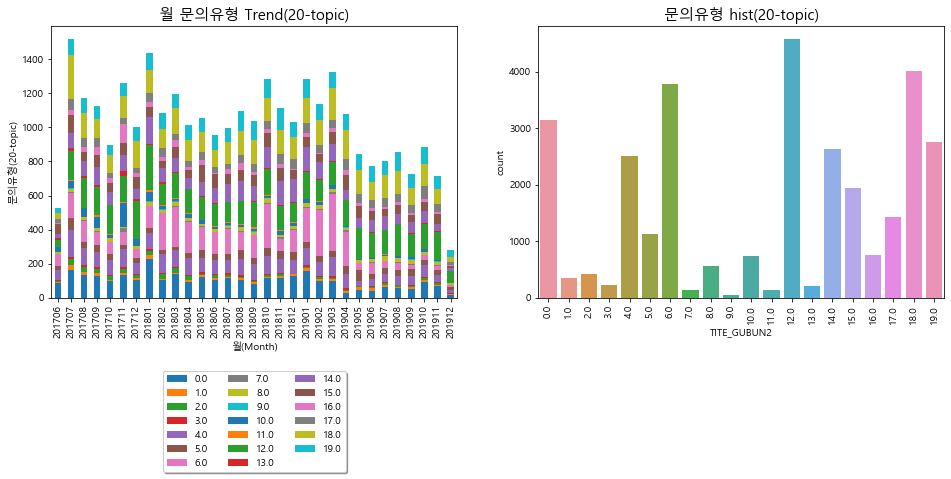

In [19]:
# 모형2 결과 시각화
mpl.rc('figure', figsize=(16, 5))

ax = plt.subplot(1,2,1)
pd.crosstab(data2_vf.REG_DTM, data2_vf.TITE_GUBUN2, data2_vf.TITE_GUBUN2, aggfunc="count").plot.bar(stacked=True, ax = ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3)
plt.xticks(rotation=90)
plt.title('월 문의유형 Trend(20-topic)',fontsize=15)
plt.xlabel('월(Month)')
plt.ylabel('문의유형(20-topic)')

ax = plt.subplot(1,2,2)
sns.countplot(x="TITE_GUBUN2", data=data2_vf)
plt.xticks(rotation=90)
# sns.countplot(x="discript", data=data1_vf)
plt.title('문의유형 hist(20-topic)',fontsize=15)

plt.show()

In [22]:
# 모형 시각화 & html 파일 저장
pyLDAvis.save_html(vis1, './LAD_topic_05_maeili_v1.html')
pyLDAvis.save_html(vis2, './LAD_topic_20_maeili_v1.html')

### 4. 토픽 모델링 결과 정리(labeling)

In [20]:
# 결과 추가정렬 : 5-topic
data1_vis = data1_vf.copy()
data1_vis['ratio'] = topictable1['각 토픽의 비중']
data1_vis['ratio_max'] = topictable1['가장 높은 토픽의 비중']
data1_vis['clean_CTT'] = data1['clean_CTT']
# data1_vis.tail()

In [21]:
from wordcloud import WordCloud

def listToString(s):  
    str1 = ""  
    for ele in s:  
        str1 += " " + ele.strip()  
    return str1

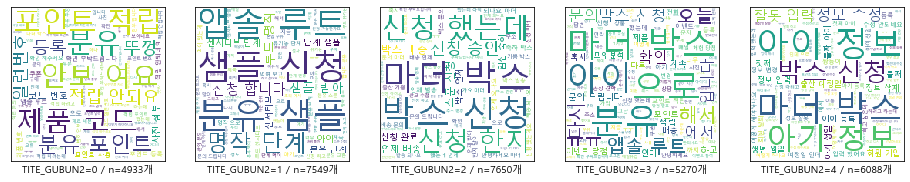

In [22]:
# 카테고리 wordcloud : 5-topic
plt.figure(figsize=(16,16))
for i in range(5):
    # text 포멧변환
    text = data1_vis[data1_vis.TITE_GUBUN2 == i]['clean_CTT'].to_list()
    text_all = listToString(text)

    # worldcloud 생성
    wc = WordCloud(path,width = 200, height = 200,  background_color="white", repeat=True)
    wc.generate(text_all)
    
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(wc, cmap=plt.cm.binary)
    plt.xlabel('TITE_GUBUN2={} / n={}개'.format(i, data1_vf.groupby('TITE_GUBUN2')['TITE_GUBUN2'].count()[i]))

plt.show()

In [27]:
data1_vf[data1_vf.TITE_GUBUN2 == 3].head(10)

,TITE_GUBUN2,text,REG_DTM
1,3.0,ghjtyu 집에갑시닷,201706
6,3.0,모유분석결과 모유분석 결과를 확인하라는 문자를받고\r\n\r\n모유분석결과보기를 아...,201706
7,3.0,아휴 아휴ㅡ\r\n문의하는해도 계속ㅡㅡ에러 뜨네요\r\n아이등록버튼 눌려도 창 넘어...,201706
16,3.0,힝 이제 집에가도 돼요?,201706
24,3.0,휴면회원이 안풀어지네요 벌써 몇번째인지 휴면회원이라 인증번호받고 푼다고 여러번시도했...,201706
26,3.0,유기농 궁 리워드 이벤트 유기농 궁 리워드 이벤트는 사이트 업그레이드 후 사라졌네요...,201706
29,3.0,오류 사이트로딩도느리고 \r\n리뉴얼된뒤로 로딩이넘느려요\r\n포인트적립하려고들어...,201706
36,3.0,서비스 뭐만할려하면 서비스점검중이라고하는데 언제쯤원할하게할수있는지요?아가키우다보면 ...,201706
37,3.0,로그인이 왜 안되죠? 아이디가 whitemisuni인데 없는 아이디라고 뜹니다. 항...,201706
41,3.0,마더박스신청관련해서 문의드려요 출산기쁨박스신청하고싶었는데 아가등록한지 한달지나서신청...,201706


In [28]:
# 속성정보 추가 : model1
data1_vf.loc[data1_vf.TITE_GUBUN2 == 0, 'descript'] = '분유적립'
data1_vf.loc[data1_vf.TITE_GUBUN2 == 1, 'descript'] = '분유상담&샘플신청'
data1_vf.loc[data1_vf.TITE_GUBUN2 == 2, 'descript'] = '마더박스'
data1_vf.loc[data1_vf.TITE_GUBUN2 == 3, 'descript'] = '로그인'
data1_vf.loc[data1_vf.TITE_GUBUN2 == 4, 'descript'] = '마더박스'

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [216]:
# 결과 추가정렬 : 20-topic
data2_vis = data2_vf.copy()
data2_vis['ratio'] = topictable2['각 토픽의 비중']
data2_vis['ratio_max'] = topictable2['가장 높은 토픽의 비중']
data2_vis['clean_CTT'] = data2['clean_CTT']
# data2_vis.tail()
data2_vf['ratio_max'] = data2_vis['ratio_max']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


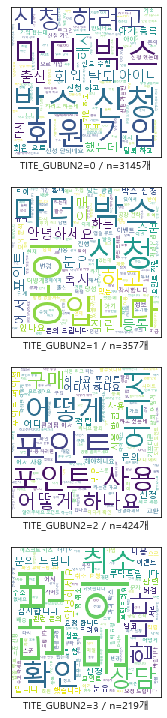

In [217]:
# 카테고리 wordcloud : 20-topic
plt.figure(figsize=(16,16))
for i in range(4):
    # text 포멧변환
    text = data2_vis[data2_vis.TITE_GUBUN2 == i]['clean_CTT'].to_list()
    text_all = listToString(text)

    # worldcloud 생성
    wc = WordCloud(path,width = 200, height = 200,  background_color="white", repeat=True)
    wc.generate(text_all)
    
    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(wc, cmap=plt.cm.binary)
    plt.xlabel('TITE_GUBUN2={} / n={}개'.format(i, data2_vf.groupby('TITE_GUBUN2')['TITE_GUBUN2'].count()[i]))

plt.show()

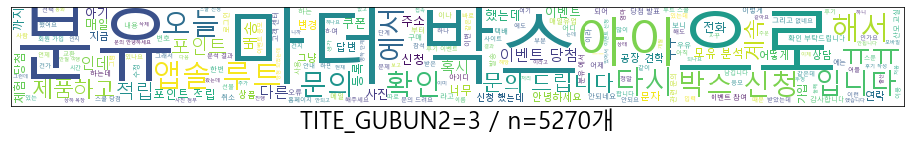

In [263]:
# 카테고리 wordcloud : 20-topic,1개만

i=3
# text 포멧변환
text = data1_vis[data1_vis.TITE_GUBUN2 == i]['clean_CTT'].to_list()
text_all = listToString(text)

# worldcloud 생성
wc = WordCloud(path,width = 900, height = 100,  background_color="white", repeat=True)
wc.generate(text_all)

plt.figure(figsize=(16,16))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(wc, cmap=plt.cm.binary)
plt.xlabel('TITE_GUBUN2={} / n={}개'.format(i, data1_vf.groupby('TITE_GUBUN2')['TITE_GUBUN2'].count()[i]), fontsize=24)

plt.show()

In [227]:
data2_vf[data2_vf.TITE_GUBUN2 == 2][['TITE_GUBUN2', 'descript','text', 'ratio_max']].tail(15)

,TITE_GUBUN2,descript,text,ratio_max
30190,2.0,이용문의,병원입력을어떻게해야하나요그리고산후조리원안가는데요 병원입력안되는데어떻게해야하나요?그리...,0.4399
30225,2.0,이용문의,한솔교육 한솔교육 제휴혜택 어떻게 적용하나요,0.3417
30296,2.0,이용문의,마더박스신청 둘째는어떻게하는건가요?,0.4253
30562,2.0,이용문의,아이수첩 인증 하는 방법 아이수첩 사진 인증 하는 방법 어디서 하는 건가요?????,0.4963
30575,2.0,이용문의,산모수첩 첨부파일은 어디다 올리나요?,0.3125
30583,2.0,이용문의,20ml 스푼 신청어디서 하는건가요?꼭 대답해주세요,0.2829
30584,2.0,이용문의,산모수첩등록 어디서하나요 응모하려면 등록하라는데 어디서하는지 모르겠어요,0.4716
30587,2.0,이용문의,"포인트 사용기한이 있나요?\r\n\r\n포인트사용은 어찌하나요,?",0.7236
30925,2.0,이용문의,쿠폰사용문의 어떻게사용하나요?\r\n문자로안왔는데..,0.4310
30993,2.0,이용문의,이건 어찌해야 합니까?😅 정립하려는데 번호가 지워져있어요\r\n이건 어찌할까용?,0.2671


In [84]:
# 속성정보 추가 : model2
data2_vf.loc[data2_vf.TITE_GUBUN2 == 0, 'descript'] = '마더박스'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 1, 'descript'] = '마더박스'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 2, 'descript'] = '이용문의'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 3, 'descript'] = '답변확인&취소'

data2_vf.loc[data2_vf.TITE_GUBUN2 == 4, 'descript'] = '마더박스'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 5, 'descript'] = '프리미엄멤버십'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 6, 'descript'] = '마더박스'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 7, 'descript'] = '분유상담'

data2_vf.loc[data2_vf.TITE_GUBUN2 == 8, 'descript'] = '분유상담'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 9, 'descript'] = '포인트적립(분유)'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 10,'descript'] = '회원정보수정(아기 외)'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 11,'descript'] = '분유셈플'

data2_vf.loc[data2_vf.TITE_GUBUN2 == 12,'descript'] = '체험단'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 13,'descript'] = '분유스푼'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 14,'descript'] = '회원정보수정(아기)'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 15,'descript'] = '마더박스'

data2_vf.loc[data2_vf.TITE_GUBUN2 == 16,'descript'] = '당첨확인'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 17,'descript'] = '회원정보수정(아기)'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 18,'descript'] = '포인트적립(분유)'
data2_vf.loc[data2_vf.TITE_GUBUN2 == 19,'descript'] = '분유상담'


### 5. 토픽 모델링 : 최종 결과 비교

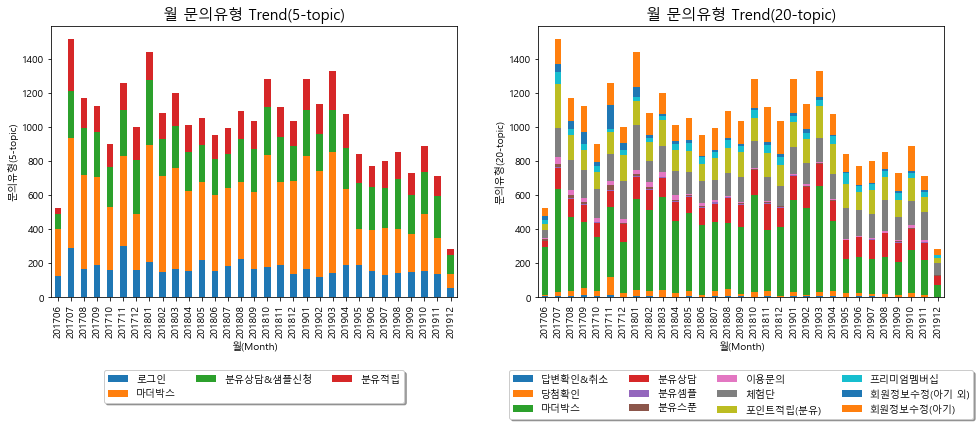

In [85]:
# 결과 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)                               # 한글폰트 설정(전역)

mpl.rc('figure', figsize=(16, 5))

ax = plt.subplot(1,2,1)
pd.crosstab(data1_vf.REG_DTM, data1_vf.descript, data1_vf.TITE_GUBUN2, aggfunc="count").plot.bar(stacked=True, ax = ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3)
plt.xticks(rotation=90)
plt.title('월 문의유형 Trend(5-topic)',fontsize=15)
plt.xlabel('월(Month)')
plt.ylabel('문의유형(5-topic)')

ax = plt.subplot(1,2,2)
pd.crosstab(data2_vf.REG_DTM, data2_vf.descript, data2_vf.TITE_GUBUN2, aggfunc="count").plot.bar(stacked=True, ax = ax)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=4)
plt.xticks(rotation=90)
plt.title('월 문의유형 Trend(20-topic)',fontsize=15)
plt.xlabel('월(Month)')
plt.ylabel('문의유형(20-topic)')

plt.show()


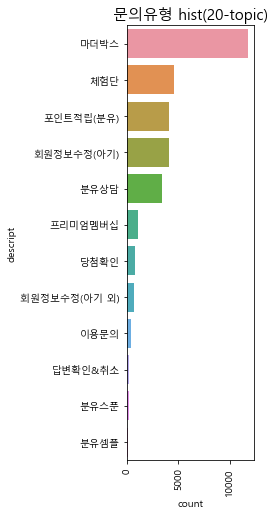

In [258]:
# 결과 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)                               # 한글폰트 설정(전역)


mpl.rc('figure', figsize=(5, 8))
# ax = plt.subplot(1,2,1)
# sns.countplot(y="descript", data=data1_vf, order = data1_vf['descript'].value_counts().index)
# plt.xticks(rotation=90)
# sns.countplot(x="discript", data=data1_vf)
# plt.title('문의유형 hist(5-topic)',fontsize=15)

ax = plt.subplot(1,2,2)
sns.countplot(y="descript", data=data2_vf, order = data2_vf['descript'].value_counts().index)
plt.xticks(rotation=90)
plt.title('문의유형 hist(20-topic)',fontsize=15)
plt.show()

### 6. 결과 저장

In [141]:
# 자료 요약내용 저장
df1 = pd.crosstab(data1_vf.REG_DTM, data1_vf.descript, data1_vf.TITE_GUBUN2, aggfunc="count")
df2 = pd.crosstab(data2_vf.REG_DTM, data2_vf.descript, data2_vf.TITE_GUBUN2, aggfunc="count")

In [142]:
# 자료 원본 저장
data['topic_05'] = data1_vf['descript']
data['topic_05_%'] = topictable1['가장 높은 토픽의 비중']

data['topic_20'] = data2_vf['descript']
data['topic_20_%'] = topictable2['가장 높은 토픽의 비중']

In [143]:
# 결과 Excel 저장
from datetime import datetime, timedelta
Today = (datetime.today()- timedelta(1)).strftime('%Y%m%d')

name = 'MI_CUS_INQUIRY_' + Today + '.xlsx'
writer = pd.ExcelWriter(name)
data.to_excel(writer, 'sheet1')
df1.to_excel(writer, 'summary_05')
df2.to_excel(writer, 'summary_20')
writer.save()

In [140]:
# Excel 저장내용
data.head(2)

,OPNN_NO,OPNN_DV_CD,CNSL_SPHR_CD,TITE,CTT,REG_DTM,text,clean_CTT,topic_05,topic_05_%,topic_20,topic_20_%
0,4,2,NaN,이벤트 궁금해요,오픈은 언제하나요...........,201706,이벤트 궁금해요 오픈은 언제하나요...........,이벤트 궁금해요 오픈 은 언 제 하나요,마더박스,0.4865,마더박스,0.3657
1,6,1,NaN,ghjtyu,집에갑시닷,201706,ghjtyu 집에갑시닷,집 에 갑시 닷,로그인,0.8088,분유상담,0.5197


In [209]:
data[data.topic_20 =='마더박스'].sort_values(by ='topic_20_%',  ascending=False).head()
# data2_vf[data2_vf.TITE_GUBUN2 == 0].tail(5)

,OPNN_NO,OPNN_DV_CD,CNSL_SPHR_CD,TITE,CTT,REG_DTM,text,clean_CTT,topic_05,topic_05_%,topic_20,topic_20_%
15544,16771,1,NaN,정회원으로 로그인,네이버로회원가입했어요\r\n마더박스 신청하려면 정회원 으로 로그인 하라고 하는데 ...,201808,정회원으로 로그인 네이버로회원가입했어요\r\n마더박스 신청하려면 정회원 으로 로그인...,정 회원 으로 로그인 네이버 로 회원 가입 했어요 마더 박스 신청 하려면 정 회원...,마더박스,0.7640,마더박스,0.9712
7960,8416,1,NaN,정회원 가입을 따로 해야하나요?,Sns아이디로 계정로그인했습니다. 마더박스 신청하려몀 정회원으로 가입해야된다고 하...,201801,정회원 가입을 따로 해야하나요? Sns아이디로 계정로그인했습니다. 마더박스 신청하...,정 회원 가입 을 따로 해야하나요 아이디 로 계정 로그 인했습니다 마더 박스 ...,마더박스,0.6413,마더박스,0.9703
10716,11390,2,NaN,마더박스받고싶은데신청이안되는건가요?,등록하고바로신청을못했는데\r\n기간이지나서신청을못하는건가요?ㅠ\r\n출산마더박스신청...,201803,마더박스받고싶은데신청이안되는건가요? 등록하고바로신청을못했는데\r\n기간이지나서신청을...,마더 박스 받고싶은데 신청 이 안되는건 가요 등록 하고 바로 신청 을 못 했는데 ...,마더박스,0.7745,마더박스,0.9703
1129,1250,1,NaN,통합회원 로그인이 안되네요.,SNS계정으로 로그인하고 정회원하기위해서 통합회원 가입을 하려고 하는데 이미 가입된...,201707,통합회원 로그인이 안되네요. SNS계정으로 로그인하고 정회원하기위해서 통합회원 가입...,통합 회원 로그인 이 안되네요 계정 으로 로그인 하고 정 회원 하 기 위해 서 ...,마더박스,0.9748,마더박스,0.9703
23810,25084,1,NaN,회원탈퇴문의,sns 로 로그인하고 회원탈퇴하려고 다시 정회원으로 회원가입하려는데요\r\n자꾸 이...,201903,회원탈퇴문의 sns 로 로그인하고 회원탈퇴하려고 다시 정회원으로 회원가입하려는데요...,회원 탈퇴 문의 로 로그인 하고 회원 탈퇴 하 려고 다시 정 회원 으로 회원 가 ...,마더박스,0.9747,마더박스,0.9694


### Appendix. 개별 내용에 대한 시각화

In [89]:
def plot_image(predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if np.max(predictions_array) > 0.5:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(" {} ({:2.0f}%)".format(true_label, 100*np.max(predictions_array)), color=color)

def plot_value_array(predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    if np.max(predictions_array) > 0.5:
        color = 'blue'
    else:
        color = 'red'
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color(color)
#     thisplot[true_label].set_color(color)

In [170]:
list(data2_vis['ratio'])[30848]

[(0, 0.010000085),
 (1, 0.010000085),
 (2, 0.010000085),
 (3, 0.010000085),
 (4, 0.010000085),
 (5, 0.010000085),
 (6, 0.010000085),
 (7, 0.010000085),
 (8, 0.010000085),
 (9, 0.010000085),
 (10, 0.010000085),
 (11, 0.010000085),
 (12, 0.010000085),
 (13, 0.010000085),
 (14, 0.010000085),
 (15, 0.010000085),
 (16, 0.010000085),
 (17, 0.010000085),
 (18, 0.80999845),
 (19, 0.010000085)]

In [169]:
len(list(data2_vis['ratio'])[30848])

20

In [159]:
for i in range(31489):
    data2_vis['len'][i] = len(list(data2_vis['ratio'])[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# data2_vis.loc[data1_vf.TITE_GUBUN2 == len(list(data2_vis['ratio'])[i]), 'len2']

In [160]:
data2_vis.head()

,TITE_GUBUN2,text,REG_DTM,ratio,ratio_max,clean_CTT,len
0,6.0,이벤트 궁금해요 오픈은 언제하나요...........,201706,"[(2, 0.18672374), (5, 0.16247027), (6, 0.36565...",0.3657,이벤트 궁금해요 오픈 은 언 제 하나요,4
1,19.0,ghjtyu 집에갑시닷,201706,"[(0, 0.012765131), (1, 0.012765131), (2, 0.012...",0.5197,집 에 갑시 닷,20
2,19.0,"마더박스가 안왓어요,. 배송이 됐다고 하는데 전혀 온게 없는데 이런일도 있는건가요?...",201706,"[(0, 0.29281095), (4, 0.18647921), (6, 0.13496...",0.3476,마더 박스 가 안왓어 요 배송 이 됐다고 하는데 전혀 온 게 없는데 이런 일도 있...,4
3,15.0,정말너무느려요. 사이트오픈하기 기다려서 엄청느린거\r\n계속 기다려서 한캔적립하니까...,201706,"[(5, 0.075837895), (7, 0.048806436), (9, 0.044...",0.5277,정말 너무 느려요 사이트 오픈 하기 기다려서 엄청 느린거 계속 기다려서 한 캔 ...,6
4,8.0,단계 변경 문의 드려요. 104일 째구요.몸무게는6키로인데 2단계로 언제 가면 될까요,201706,"[(3, 0.1095222), (8, 0.83422685)]",0.8342,단계 변경 문의 드려요 일 째구요 몸무게 는 키로 인데 단계 로 언제 가면 ...,2


In [171]:
data2_vis.loc[data2_vis.len == 20].tail(3)

,TITE_GUBUN2,text,REG_DTM,ratio,ratio_max,clean_CTT,len
31147,17.0,등록안됨 등록안되요\r\n,201911,"[(0, 0.010000397), (1, 0.010000397), (2, 0.010...",0.8100,등록 안됨 등록 안되요,20
31259,0.0,아이디 연결 카카오톡 bumkyuhan,201912,"[(0, 0.5125427), (1, 0.012502672), (2, 0.01250...",0.5125,아이디 연결 카카오 톡,20
31372,18.0,이거슨 글씨가 안보임요,201912,"[(0, 0.010000164), (1, 0.010000164), (2, 0.010...",0.6100,이거슨 글씨 가 안 보임요,20


In [ ]:
data1_vf.loc['len2'] = len(list(data2_vis['ratio']))

In [177]:
i=31146
pred= ()
for x, y in list(data2_vis['ratio'])[i]: # enumerate 결과와 동일한 format임
    pred = np.append(pred, y) 

In [179]:
list(data2_vis['ratio'])[i]

[(0, 0.11672002),
 (1, 0.07313116),
 (2, 0.026648963),
 (6, 0.12634498),
 (14, 0.082821906),
 (15, 0.31751394),
 (16, 0.20304812),
 (17, 0.025413442),
 (18, 0.021302748)]

In [180]:
pred = np.array([0.11672002, 0.07313116, 0.02664896, 0.00000000, 0.00000000, 
                 0.00000000, 0.12634498, 0.00000000, 0.00000000, 0.00000000, 
                 0.00000000, 0.00000000, 0.00000000, 0.00000000, 0.08282191,
                 0.31751394, 0.20304812, 0.02541344, 0.02130275, 0.00000000])

확인 colunm : 31147

-------------------원   본-----------------------
등록안됨 등록안되요


-------------------1차변환-----------------------
['등록', '안됨', '등록', '안되요', '\r\n']

-------------------2차변환-----------------------
등록 안됨 등록 안되요 

-------------------3차변환-----------------------
['등록', '안됨', '등록', '안되요']

--------------Wordcloud & 확률분포---------------


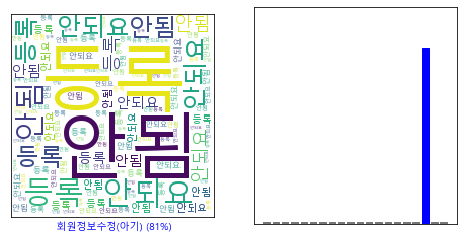

In [182]:
# 목표 결과물

# i =  data.sample(n=1, axis =0).index[0]
i=31147

print('확인 colunm : {}'.format(i) )
print('\n-------------------원   본-----------------------')
print(data['text'][i])        # 원본
print('\n-------------------1차변환-----------------------')
print(data_trim1[i])          # 1차 변환
print('\n-------------------2차변환-----------------------')
print(data['clean_CTT'][i])   # 2차 변환
print('\n-------------------3차변환-----------------------')
print(data_trim3[i])          # 3차 변환

# print(data['text'][i])        # 원본

pred= ()
for x, y in list(data2_vis['ratio'])[i]: # enumerate 결과와 동일한 format임
    pred = np.append(pred, y) 


# Wordcloud 
text = data2_vis['clean_CTT'].to_list()[i]

wc = WordCloud(path, width = 200, height = 200,  background_color="white", repeat=True)
wc.generate(text)    


print('\n--------------Wordcloud & 확률분포---------------')
# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_image(pred, data2_vf['descript'][i], wc)
plt.subplot(1,2,2)
plot_value_array(pred, data2_vf['descript'][i])
plt.show()

In [183]:
pred

array([0.0100004 , 0.0100004 , 0.0100004 , 0.0100004 , 0.0100004 ,
       0.0100004 , 0.0100004 , 0.0100004 , 0.0100004 , 0.0100004 ,
       0.0100004 , 0.0100004 , 0.0100004 , 0.0100004 , 0.0100004 ,
       0.0100004 , 0.0100004 , 0.80999249, 0.0100004 , 0.0100004 ])